In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
print(torch.cuda.is_available())

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

True


In [2]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()     
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()     
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

In [3]:
def mini_batch(device, data_loader, step_fn, should_permute = False):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        if should_permute:
            x_batch, y_batch = permute_particles(x_batch, y_batch, n_particles=NUM_PARTICLES)
        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

In [4]:
def permute_particles(x, y, n_particles):
    # Generate a random permutation
    perm = torch.randperm(n_particles)
    # Apply the permutation
    x_permuted = x[:, perm, :]
    y_permuted = y[:, perm, :]
    return x_permuted, y_permuted

In [5]:
# Model Configuration
class Model1(nn.Module):
    def __init__(self, n_particles, degrees_of_freedom, n_layers=10):
        super().__init__()
        n_features = n_particles * degrees_of_freedom
        # Define the layers in a ModuleList
        self.flatten = nn.Flatten()
        # Define unflatten with a fixed size assuming the flattened size is n_particles * degrees_of_freedom
        self.unflatten = nn.Unflatten(1, (n_particles, degrees_of_freedom))
        layers = [nn.Linear(in_features=n_features, out_features=n_features) for _ in range(n_layers)]
        self.layers = nn.ModuleList(layers)
        # Define the activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        # Iterate through all linear layers except the last to apply ReLU activation
        for layer in self.layers[:-1]:
            x = self.relu(layer(x))
        x = self.layers[-1](x)  # Apply the last linear layer without activation
        x = self.unflatten(x)  # Unflatten to the original shape
        return x

In [3]:
# Load data
loaded_trajectory_pos = np.load('trajectory_pos.npy', allow_pickle=True)
N_STEPS = len(loaded_trajectory_pos)
NUM_PARTICLES = loaded_trajectory_pos[0].shape[0]
LX = 5. # BOX WIDTH
LY = 5.  # BOX HEIGHT
DEG_FREED = 2 # degrees of freedom, here x and y coordinates
N_FEATURES = NUM_PARTICLES * DEG_FREED
print('N_STEPS =', N_STEPS)
print('NUM_PARTICLES =', NUM_PARTICLES)
print('N_FEATURES =', N_FEATURES)

N_STEPS = 1001
NUM_PARTICLES = 12
N_FEATURES = 24


In [7]:
print(type(loaded_trajectory_pos))
print(loaded_trajectory_pos.shape)
print(type(loaded_trajectory_pos[0,0,0]))
print(loaded_trajectory_pos[0,:,0])

<class 'numpy.ndarray'>
(1001, 12, 2)
<class 'numpy.float64'>
[4.99354159 4.99762108 0.00585147 0.00590268 1.45063437 1.44080783
 1.44438815 1.44709421 2.88388515 2.88026162 2.88254594 2.88681452]


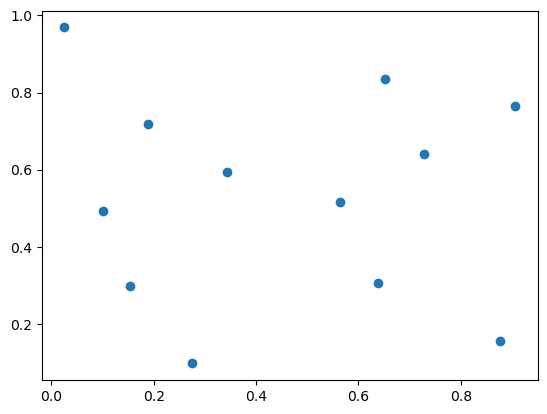

In [6]:
#trajectory[t,n,i]
#t-> time step
#n-> particle
#i-> x or y coordinate
t = -1 #last time step
plt.scatter(loaded_trajectory_pos[t,:,0]/LX, loaded_trajectory_pos[t,:,1]/LY, marker='o')

In [9]:
# Data preparation

#input X is the time step t; output Y the time step t+1
x = loaded_trajectory_pos[0:N_STEPS-1,:,:]/LX
y = loaded_trajectory_pos[1:N_STEPS,:,:]/LY
print(x.shape)
print(y.shape)
print(np.array_equal(x[1],y[0]))#just to check that the shifted time steps are correct

(1000, 12, 2)
(1000, 12, 2)
True


In [10]:
# Data preparation

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
#x_tensor, y_tensor = permute_particles(x_tensor, y_tensor, n_particles=NUM_PARTICLES)
print('unflattened x size ', x_tensor.shape)
print('unflattened y size ', y_tensor.shape)
#Just to check that flatten and unflatten works
flatten = nn.Flatten() # Instantiate a Flatten layer
x_flat = flatten(x_tensor)
y_flat = flatten(y_tensor)
print('flattened x size ', x_flat.shape)
print('flattened y size ', y_flat.shape)
unflatten = nn.Unflatten(1, (NUM_PARTICLES, DEG_FREED)) #'1' means unflat the 2nd dimension in (NUM_PARTICLES, DEG_FREED)
x_unflat = unflatten(x_flat)
y_unflat = unflatten(y_flat)
print('re-unflattened x size ', x_unflat.shape)
print('re-unlattened x size ', y_unflat.shape)
print('does unflat x work? ', torch.equal(x_tensor, x_unflat))
print('does unflat y work? ', torch.equal(y_tensor, y_unflat))

# Builds dataset containing ALL unflatten data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

unflattened x size  torch.Size([1000, 12, 2])
unflattened y size  torch.Size([1000, 12, 2])
flattened x size  torch.Size([1000, 24])
flattened y size  torch.Size([1000, 24])
re-unflattened x size  torch.Size([1000, 12, 2])
re-unlattened x size  torch.Size([1000, 12, 2])
does unflat x work?  True
does unflat y work?  True


In [11]:
# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [12]:
# Training loop Configuration

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Model1(n_particles=NUM_PARTICLES, degrees_of_freedom=DEG_FREED, n_layers=5)
#N_FEATURES=DEG_FREED*NUM_PARTICLES: x and y coordinates for each particle
model.to(device)
# Defines an optimizer to update the parameters  retrieved directly from the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

In [13]:
#Training no permutation
n_epochs = 400
losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn, should_permute = False)
    losses.append(loss)  
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    if epoch % (n_epochs//5) == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Val loss: {val_loss:.3f}")


Epoch: 0 | Train loss: 0.236 | Val loss: 0.113
Epoch: 80 | Train loss: 0.002 | Val loss: 0.002
Epoch: 160 | Train loss: 0.001 | Val loss: 0.002
Epoch: 240 | Train loss: 0.001 | Val loss: 0.002
Epoch: 320 | Train loss: 0.001 | Val loss: 0.001


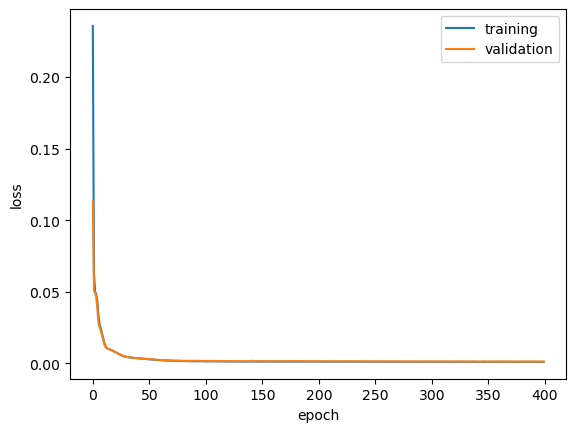

In [14]:
plt.plot(losses, label = 'training')
plt.plot(val_losses, label = 'validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

without permutations is decent, but it learns the data not the physics; in fact if I permute it is terrible.

(1000, 12, 2)
(1000, 12, 2)


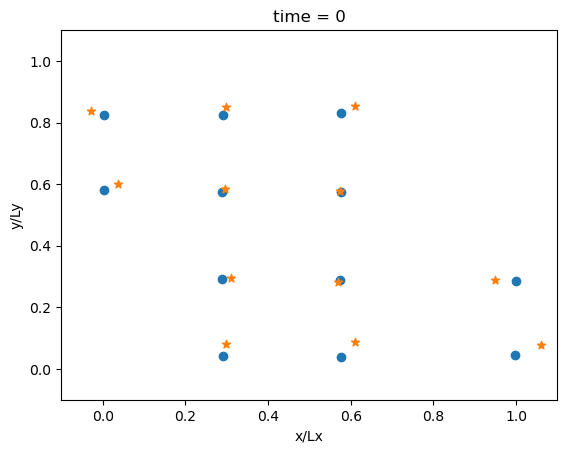

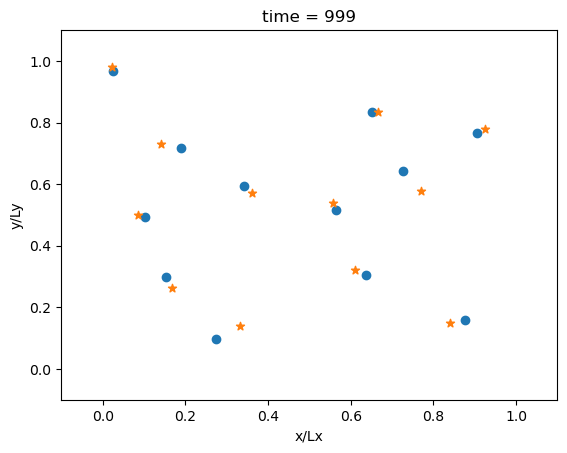

1000
1000
1000


In [45]:
#compare full trajectories step-by-step
real_xy = np.zeros_like(x_unflat)
predicted_xy = np.zeros_like(x_unflat)
model.eval()
for i in range(len(x_unflat)):
    pos_t_1 = x_unflat[i].unsqueeze(0)
    pos_t = y_unflat[i].unsqueeze(0)
    with torch.inference_mode(): predicted_t = model(pos_t_1.to(device))
    real_xy[i] = pos_t.numpy()
    predicted_xy[i] = predicted_t.cpu().numpy()
    
print(real_xy.shape)
print(predicted_xy.shape)
time = 0
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o')
plt.scatter(predicted_xy[time,:,0], predicted_xy[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()
time = N_STEPS - 2 
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o')
plt.scatter(predicted_xy[time,:,0], predicted_xy[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()
print(len(x_unflat))
print(len(real_xy))
print(len(predicted_xy))

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_video(real_y, pred_y, file_name):
    # Update function for the animation
    def update(frame_number, real_y, pred_y, scatter_real, scatter_pred, time_text):
        # Update the data of both scatter plots for the new frame
        scatter_real.set_offsets(real_y[frame_number])
        scatter_pred.set_offsets(pred_y[frame_number])
        # Update the time annotation
        time_text.set_text(f'Time = {frame_number}')
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('x/Lx')
    ax.set_ylabel('y/Ly')    
    # Create initial scatter plots and a text annotation
    scatter_real = ax.scatter(real_y[0, :, 0], real_y[0, :, 1], color='blue', marker='o')
    scatter_pred = ax.scatter(pred_y[0, :, 0], pred_y[0, :, 1], color='orange', marker='*')
    time_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center')
    
    # Create the animation using FuncAnimation
    ani = FuncAnimation(fig, update, frames=len(real_y), fargs=(real_y, pred_y, scatter_real, scatter_pred, time_text), interval=100)
    
    # Save the animation
    ani.save(file_name, writer='ffmpeg')
    
    # Convert the animation to an HTML5 video embedded in the notebook
    html = HTML(ani.to_html5_video())
    
    # Close the figure to prevent it from displaying in the notebook or script output
    plt.close(fig)
    
    # Return the HTML object to display the animation in the notebook
    return html

In [47]:
make_video(real_xy, predicted_xy, file_name = 'predicted.mp4')

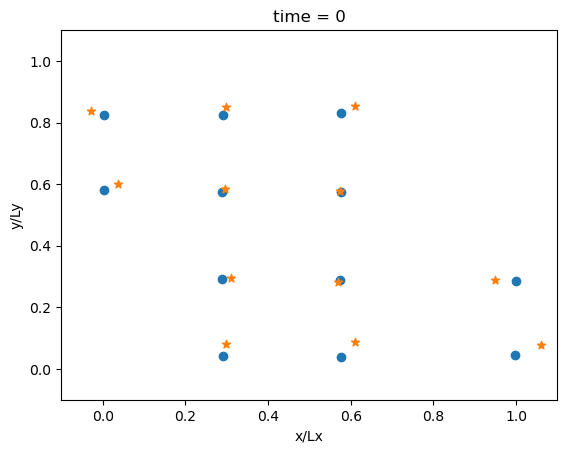

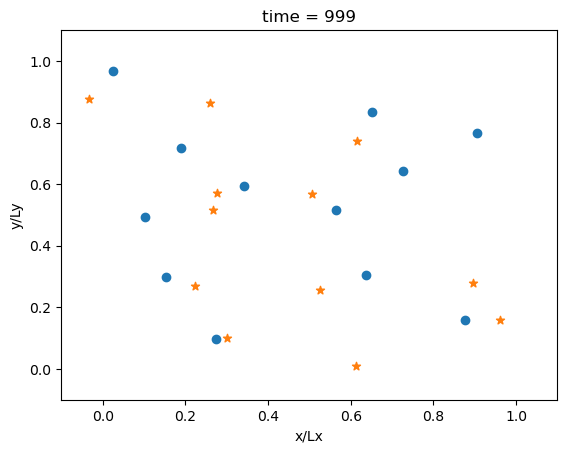

In [44]:
#compare full trajectories fully predicted 
fully_predicted_xy = np.zeros_like(x_unflat)
pos_t_1 = x_unflat[0].unsqueeze(0)
model.eval()
for i in range(len(x_unflat)):
    with torch.inference_mode(): predicted_t = model(pos_t_1.to(device))
    fully_predicted_xy[i] = predicted_t.cpu().numpy()
    pos_t_1 = predicted_t

time = 0
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o')
plt.scatter(fully_predicted_xy[time,:,0], fully_predicted_xy[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()
time = N_STEPS - 2
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o')
plt.scatter(fully_predicted_xy[time,:,0], fully_predicted_xy[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()

In [19]:
make_video(real_xy, fully_predicted_xy, file_name = 'fully_predicted.mp4')

In [40]:
# Calculate squared differences for x and y coordinates
d1 = ((real_xy[:, :, 0] - predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - predicted_xy[:, :, 1])**2)
d2 = ((real_xy[:, :, 0] - fully_predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - predicted_xy[:, :, 1])**2)
# Sum the errors for all particles at each time step
overall_error_per_timestep1 = np.sum(d1, axis=1)
overall_error_per_timestep2 = np.sum(d2, axis=1)

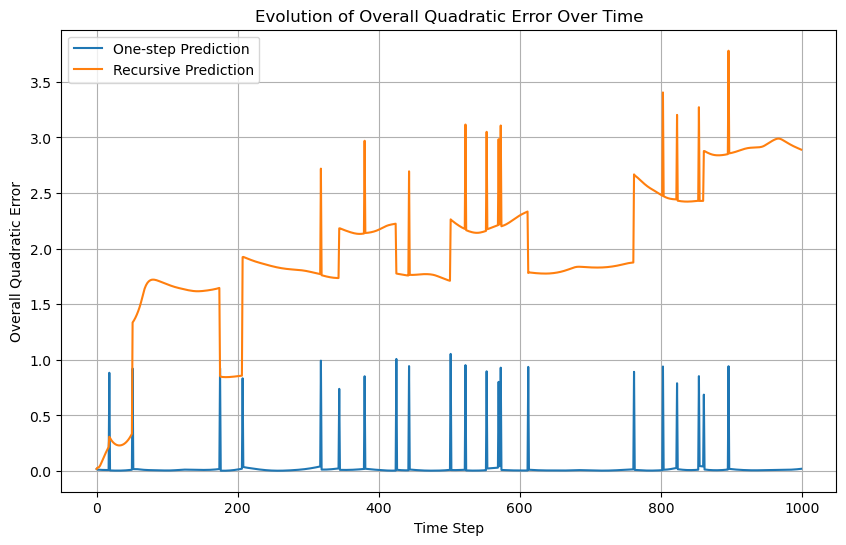

In [48]:
time_steps = np.arange(len(overall_error_per_timestep1))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, overall_error_per_timestep1, label='One-step Prediction')
plt.plot(time_steps, overall_error_per_timestep2, label='Recursive Prediction')
plt.xlabel('Time Step')
plt.ylabel('Overall Quadratic Error')
plt.title('Evolution of Overall Quadratic Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

the peaks depend on the boundary conditions